# Amazon Satelite Image Classification

## Data Source

For this analysis data has been taken from kaggle [here](https://www.kaggle.com/datasets/prosperchuks/amazonsatelliteimages) is the dataset.
This dataset consists of amazon satelite images and classified each image on the basis of a few tags.

# Imports

In [1]:
import numpy
import pandas
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import AUC,Metric, Precision, Recall
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
import os
import random
import matplotlib.pyplot as plt

## Loading the dataset and exploring it

Let's start by loading the image data, we will be storing the data to a list

In [2]:
imgs=[]
flName=[]
for ind,i in enumerate(os.listdir("train-jpg/train-jpg")):
#     Loading only first 5 thousand images into memory
    if ind==5000:
        break
    img=plt.imread("train-jpg/train-jpg/"+i)
    imgs.append(img)
    flName.append(i)

let's start by randomly plotting the first image

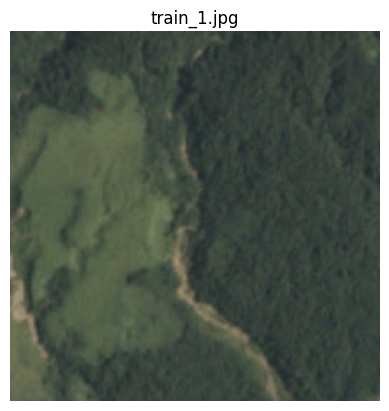

In [3]:
plt.imshow(imgs[1])
plt.title(flName[1])
plt.axis('off')
plt.show()

In [4]:
labels=pandas.read_csv("train_v2.csv/train_v2.csv")

In [5]:
labels.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Now we want to find all the possible tags:

In [7]:
allImageTags=set(labels.tags)
everything=""
for i in allImageTags:
    everything+=" "+i+" "
everything=everything.split(" ")
print(len(set(everything)))
set(everything)

18


{'',
 'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

So, there are 17 tags (not including that empty string) , now lets find out how many images we have for each tag

In [9]:
count={}
for i in set(everything):
    if i!='':
        count[i]=0
        
for j in labels.tags:
    for i in set(everything):
        if i!="" and i in j:
            count[i]+=1
count

{'conventional_mine': 100,
 'cultivation': 4477,
 'agriculture': 12315,
 'bare_ground': 862,
 'selective_logging': 340,
 'road': 8071,
 'partly_cloudy': 7261,
 'artisinal_mine': 339,
 'cloudy': 9350,
 'clear': 28431,
 'blow_down': 98,
 'habitation': 3660,
 'primary': 37513,
 'haze': 2697,
 'blooming': 332,
 'slash_burn': 209,
 'water': 7411}

Its better if we visualize this data for even better understanding.

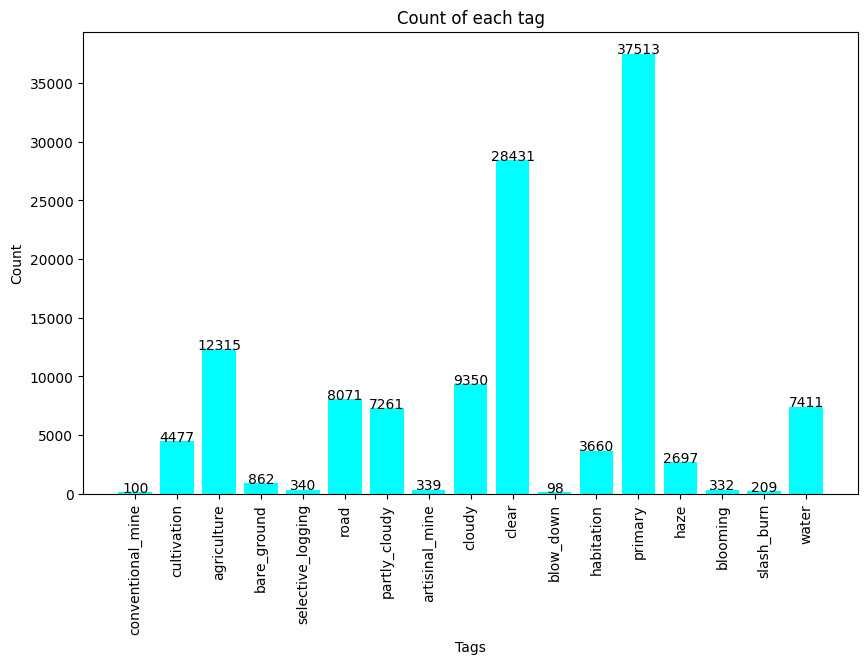

In [11]:
plt.figure(figsize=(10,6))
plt.bar(count.keys(),count.values(),color='cyan')
for i, v in enumerate(count.values()):
    plt.text(i, v, str(v), ha='center')
plt.xticks(rotation=90)
plt.title("Count of each tag")
plt.xlabel("Tags")
plt.ylabel("Count")
plt.savefig("CountOfTags.png")
plt.show()

We won't require the 'imgs' variable anymore, so its better if we delete it as its going to reserve soo much memory

In [12]:
del imgs

### More preprocessing with data

In [13]:
labels.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [15]:
allTags=set(everything)

In [16]:
allTags

{'',
 'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

In [18]:
allTags.remove('')

In [19]:
def createColumns(row):
    tags = row['tags'].split(" ")
    for tag in allTags:
        row[f'is_{tag}'] = int(tag in tags)
    return row

labels=labels.apply(createColumns,axis=1)

In [20]:
def addJpg(row):
    return row+'.jpg'

labels['image_name']=labels['image_name'].apply(addJpg)

In [21]:
labels.head()

In [22]:
labels.to_csv("newLabels.csv")

Now we as we have classified this as binary columns now we can move to the X data

## Loading new data and working with it

In [23]:
labels = pandas.read_csv('newLabels.csv')

In [24]:
labels.head()

,Unnamed: 0,image_name,tags,is_cloudy,is_water,is_habitation,is_partly_cloudy,is_conventional_mine,is_agriculture,is_slash_burn,is_blow_down,is_primary,is_artisinal_mine,is_cultivation,is_bare_ground,is_selective_logging,is_road,is_blooming,is_haze,is_clear
0,0,train_0.jpg,haze primary,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,1,train_1.jpg,agriculture clear primary water,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
2,2,train_2.jpg,clear primary,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,3,train_3.jpg,clear primary,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,4,train_4.jpg,agriculture clear habitation primary road,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1


In [26]:
labels.columns

Index(['Unnamed: 0', 'image_name', 'tags', 'is_cloudy', 'is_water',
       'is_habitation', 'is_partly_cloudy', 'is_conventional_mine',
       'is_agriculture', 'is_slash_burn', 'is_blow_down', 'is_primary',
       'is_artisinal_mine', 'is_cultivation', 'is_bare_ground',
       'is_selective_logging', 'is_road', 'is_blooming', 'is_haze',
       'is_clear'],
      dtype='object')

In [28]:
import os
# tweaking an environment variable to remove a Tensorflow error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Data Splitting and model training

we will be using a ResNet50 model as the base model, this would help us to increase our accuracy as ResNet50 is a pre-trained model on a large variety of image

In [29]:
base = ResNet50(weights='imagenet', include_top=False)

Now we will be splitting the data into a training set and a testing set/validation set

In [30]:
training, validation = train_test_split(labels, test_size=0.2, random_state=1)

Creating datagenerators for testing and training data and going through feature selection procedure

In [31]:
# Directory of the images that we are going to use
data = 'train-jpg'

# Training DataGenerator
trainDatagen=ImageDataGenerator(rescale=1./255)
trainGen=datagen.flow_from_dataframe(
        training, directory=data, x_col='image_name', y_col=['is_cloudy', 'is_water','is_habitation', 'is_partly_cloudy', 'is_conventional_mine',
       'is_agriculture', 'is_slash_burn', 'is_blow_down', 'is_primary','is_artisinal_mine', 'is_cultivation', 'is_bare_ground',
       'is_selective_logging', 'is_road', 'is_blooming', 'is_haze','is_clear'],
        target_size=(224,224), batch_size=32, class_mode='raw')


# Testing DataGenerator
testDatagen=ImageDataGenerator(rescale=1./255)
testGen=datagen.flow_from_dataframe(
        validation, directory=data, x_col='image_name', y_col=['is_cloudy', 'is_water','is_habitation', 'is_partly_cloudy', 'is_conventional_mine',
       'is_agriculture', 'is_slash_burn', 'is_blow_down', 'is_primary','is_artisinal_mine', 'is_cultivation', 'is_bare_ground',
       'is_selective_logging', 'is_road', 'is_blooming', 'is_haze','is_clear'],
        target_size=(224,224), batch_size=32, class_mode='raw')
 

Found 32383 validated image filenames.
Found 8096 validated image filenames.


Creating the model structure, adding base model and adding more layers to it

In [32]:
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(17, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=predictions)

Now lets freeze the base model layers, to avoid inturruptions and problems

In [33]:
for layer in base.layers:
    layer.trainable = False

Now lets finally train our model!

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

In [35]:
model.fit(train_generator, epochs=3, validation_data=val_generator)

Epoch 1/3
1012/1012 [==============================] - 3039s 3s/step - loss: 0.2569 - auc: 0.9071 - val_loss: 0.2578 - val_auc: 0.9188
Epoch 2/3
1012/1012 [==============================] - 2925s 3s/step - loss: 0.2457 - auc: 0.9176 - val_loss: 0.2351 - val_auc: 0.9279
Epoch 3/3
1012/1012 [==============================] - 2629s 3s/step - loss: 0.2264 - auc: 0.9311 - val_loss: 0.2161 - val_auc: 0.9391


## Model Evalution and testing

In [37]:
def pred(model, img_path, img_size=(224, 224)):
    # Loading and preprocessing image
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = numpy.expand_dims(x, axis=0)
    x = x / 255.0

    # Making a prediction
    preds = model.predict(x)

    return preds


1/1 [==============================] - 2s 2s/step
[0.027964082, 0.24616121, 0.09296366, 0.25492945, 0.0030362876, 0.41955853, 0.0053074025, 0.0023553653, 0.9498194, 0.0033479931, 0.12303443, 0.026435057, 0.0059666038, 0.26431718, 0.0053513637, 0.055840626, 0.5683313]


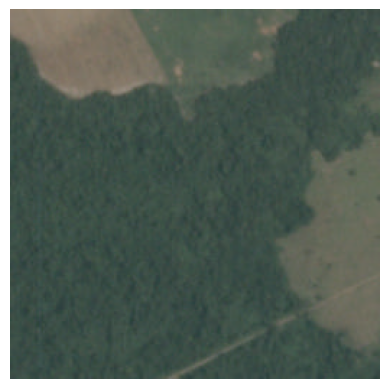

1/1 [==============================] - 0s 93ms/step
[0.0010218419, 0.12607439, 0.04958781, 0.12251562, 0.0010555459, 0.21507789, 0.004147301, 0.0027494207, 0.99694693, 0.00087563833, 0.12767676, 0.013170941, 0.011631508, 0.11944879, 0.0135919405, 0.010715006, 0.91521794]


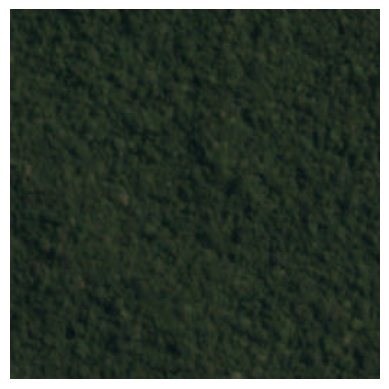

1/1 [==============================] - 0s 149ms/step
[0.14801094, 0.34311906, 0.15629962, 0.37209204, 0.0055223126, 0.4855758, 0.004526882, 0.0013499554, 0.7819248, 0.011760839, 0.0955149, 0.040880177, 0.003012898, 0.41036823, 0.0018039511, 0.06307578, 0.27713427]


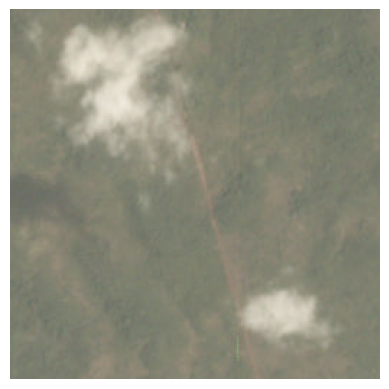

1/1 [==============================] - 0s 188ms/step
[0.484489, 0.35541302, 0.10978383, 0.34274474, 0.0049800603, 0.43870914, 0.0035371836, 0.00090214104, 0.46706647, 0.009307437, 0.067384645, 0.03796043, 0.0014392918, 0.36797386, 0.0009952484, 0.15818085, 0.1399884]


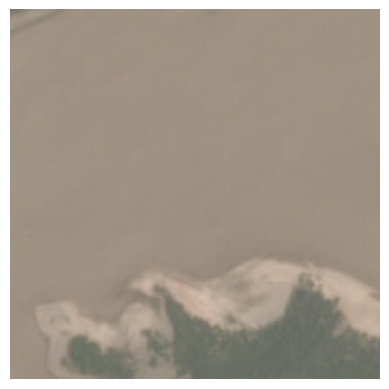

1/1 [==============================] - 0s 167ms/step
[0.0023969351, 0.15579093, 0.06355649, 0.15730803, 0.001551989, 0.27588338, 0.0049249143, 0.0030638261, 0.99370056, 0.0013890748, 0.13535702, 0.016939804, 0.011246593, 0.15671936, 0.0120954905, 0.016820427, 0.8637701]


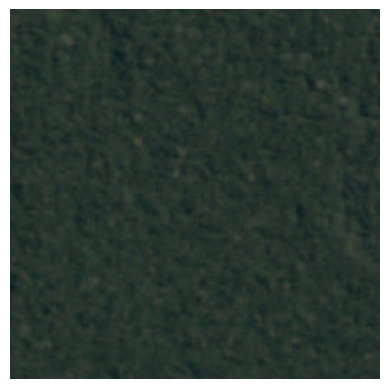

In [38]:
def predWithImage(img_path, probs):
    img = image.load_img(img_path)
    print(probs)
    plt.figure()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Testing Directory
test_data_dir = 'test-jpg'

# Randomly taking any 5 images from the directory
test_images = random.sample(os.listdir('mini'), 5)

# Predicting each and every image
for img_name in test_images:
    img_path = os.path.join('D:/EcoSight/amazon dataset ml/EcoLife-Geek-a-thon-project/Amazon Model Development/train-jpg/'+img_name)
    preds = pred(model, img_path)
    p=[]
    for i in range(17):
        p.append(preds[0][i])
#     agriculture ,mine,empty,bloom,blow,clear,cloudy,convMine,cultivation,deforestation,haze,partlyCloudy,primary,road,logging,pollution,water
#    This is how they are arranged.
    predWithImage(img_path, p)
    


## Exporting the model for later use

In [39]:
model.save('SuperImpModel.h5')

C:\Users\swadh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
